Get the difference between nucleus and TFS set of words. See if the words in this set are reasonable. They should be reasonable for when TFS is looser and should not be when TFS is tighter. Out of this set of words, take the highest, lowest prob ones and the middle one? Need at least 3 word gap between them. 
Rank each one in how reasonable it is. Control baseline is how reasonable words at different points in the body are. The first word, half way and at the closer of the tails. Can also get words outside of the last tail, just outside, halfway to the end, and at the very end. 
There are 9 different words in total. Should i rank all of them, scramble up a subset? Or have a ranking for each of the subsets differently? Probably scramble them all up. And then present 3 of them??
Can then see overall how replaceable different parts of the distributions is, and for TFS and nucleus specifically. Have a control with the bad words. And should be able to hopefully show that the difference in replaceability between the TFS and nucleus words is small when TFS is looser and large when TFS is tighter. Can see how specific this is also. Eg could just look at the last TFS and nucleus words, see the diff in replaceability, or maybe need to look at the averages. Look most at this unique subset and these three points should hopefully categorize it. Want them because i dont know how good the signal is going to be. For the closest words for example. 
Can also get overall data on how replaceability corresponds to model probability. 


In [1]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

In [2]:
from decodeLogits import *

In [3]:
#updated
vals_dict = {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99],
'n': [0.5, 0.63, 0.69, 0.81, 0.75, 0.9], 'k':[1,40,200]  }


''' {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],
'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9], 'k':[1,10,40,200]  }'''

" {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],\n'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9], 'k':[1,10,40,200]  }"

# Doing analysis for the same logit going to use the ground truth as it is a Schelling point

In [4]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [5]:
batch_size=25
num_batches=4
prompt_length=100
generated_length=150
tot_len = prompt_length+generated_length

import encoder
from decodeLogits import *
model_name='774M' #345M
models_dir='../gpt-2/models'
enc = encoder.get_encoder(model_name, models_dir)

prompts=pd.read_csv('test_dataframe_500primer.csv')

In [6]:
gpt_out_path = 'gpt-2_output/'
additional_path = '-model_774M-seed_27'#'' 
#all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb'))
all_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb')) # needed to get the probabilities
text = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb'))

In [7]:
tot_num = 0
mapping_to_batch = dict()
for i in range(num_batches):
    num_in_batch = all_logits[i].shape[0]
    for el, b_ind in zip(range(tot_num, tot_num+num_in_batch), range(0, num_in_batch)):
        mapping_to_batch[el] = (i, b_ind) # actual batch and then the ind in that batch
    print( num_in_batch)
    tot_num+= num_in_batch
tot_num

23
23
24
22


92

In [8]:
all_logits[0].shape

(23, 150, 50257)

# Want to generate things that are at the different probability levels

# Looking at max deviation and getting these points within the tails of each

## Want to also focus on the maximum deviation portions at some point. 

In [10]:
np.random.seed(29) # 1 used 27, 2 used 28, 3 used 29. 

In [11]:
# random prompts and locations within the 150 generation locations

num_prompts_and_timepoints_wanted = 50 # cant be larger than 100 right now!!!
assert num_prompts_and_timepoints_wanted <=100
leading_prompt = 15

want_min_max = False

if want_min_max==True:
    minmax = pd.read_csv('Min_Max_Disagreement_Coords_TFS90.csv')
    #shuffle it and take the number that is wanted. 
    minmax = minmax.sample(frac= num_prompts_and_timepoints_wanted/minmax.shape[0])
    display(minmax.head())
    
else:
    rand_prompts = np.random.randint(0,tot_num, num_prompts_and_timepoints_wanted)
    # leadingprompt until 150. as the logits are 150 not 250. 
    # -1 because of the end token prediction
    rand_times = np.random.randint(0,generated_length-1, num_prompts_and_timepoints_wanted)

In [12]:
len(all_logits[0][0, :, 0])

150

getting random locations
for the differnet gen strategies. find the tail locations. take the tokens at each position. 
move onto the next random location. 

In [13]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [14]:
enc = encoder.get_encoder(model_name, models_dir)

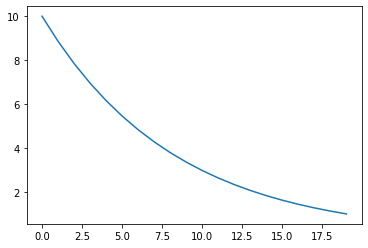

In [20]:
plt.plot(np.arange(20), np.logspace(1,0,20))

In [64]:
# applying all analyses to the logits. 
prompt_length = 100
slices_from_each = 6 # as one will also be the ground truth word. 
to_df = []

# randomly select generations and positions in those generations. from the original prompts. 
for r_ind in range(0, num_prompts_and_timepoints_wanted):
    
    if want_min_max ==True:
        prompt = 999
        batch_ind, ind_in_batch = minmax.iloc[r_ind, 1], minmax.iloc[r_ind, 2]
        time_point = minmax.iloc[r_ind,3]
        if time_point>=149:
            continue # because of the stop token being predicted. 
        text_timepoint = time_point+prompt_length+1 # +1 because the perplexities keeps the end prediction token. 
    else:
        prompt = rand_prompts[r_ind]
        time_point = rand_times[r_ind]
        text_timepoint = time_point+prompt_length+1 # +1 because the perplexities keeps the end prediction token. 
        batch_ind, ind_in_batch = mapping_to_batch[prompt]
    
    sps_no_sort = softmax(all_logits[batch_ind][ind_in_batch, time_point, :])
    sps = softmax(-np.sort(-all_logits[batch_ind][ind_in_batch, time_point, :]))
    
    prob_slices_wanted = np.linspace(sps[0],0,slices_from_each)/3
    
    indices = np.argsort(-all_logits[batch_ind][ind_in_batch, time_point, :])
    ground_token = text[batch_ind][ind_in_batch][text_timepoint]
    print('ground token', ground_token)
    prev_token = text[batch_ind][ind_in_batch][text_timepoint-1]
    prev_prev_token = text[batch_ind][ind_in_batch][text_timepoint-2]
    prev_tokens = [ground_token, prev_token,prev_prev_token]
    
    # check if these are even real words first 
    real_prompt_words, _ = remove_non_words(prev_tokens, wantPrint=False)
    #print(real_prompt_words)
    if len(real_prompt_words)<len(prev_tokens):
        print('one of the three tokens in front were not words so skipping')
        continue
        
    else: 
        ground_word = decoder_text([ground_token])
        print('decoded ground word', ground_word)
        #stripped_prev_tokens.append(space_free[0])

        #ground_word = stripped_prev_tokens[-1]]) #[ground_token])
        # what the ground token is
        ground_word_prob = sps_no_sort[ground_token]
        
        print('ground word prob is: ', ground_word_prob)
        print('sorted indices', indices[:10])
    
    #get the 15 words in front. 
    lead_prompt_words = decoder_text(text[batch_ind][ind_in_batch][text_timepoint-leading_prompt:text_timepoint])
    df_row = [prompt, time_point, batch_ind, ind_in_batch, lead_prompt_words, ground_word, ground_word_prob] # taking it from the last one. 
    
    print('ten sps values', sps[0:10])
    print('prob slices:', prob_slices_wanted)
    
    #remove any non word tokens from whole list. (could be done more efficiently)
    real_word_tokens, abs_pos = remove_non_words(indices)
    
    real_word_probs = sps[np.asarray(abs_pos)]
    
    rel_to_abs_index = {rel:absolute for rel, absolute in zip(range(len(abs_pos)), abs_pos )}
    
    # select the right positions and words: 
    #NEED TO IGNORE ANY OF THE SLICES THAT ARE TOO LARGE.  TAKE THE HIGHEST PROB WORD AND THEN DO THE SLICES.
    
    # TAKING SPECIFIC PROBS RATHER THAN PROB SLICES AS BEFORE
    first = sps[1:] - sps[:-1]
    second = first[1:] - first[:-1]
    tail_id = new_tfs(second, 0.9)
               
    tail_id_nuc = nucleus_calc(sps, 0.63)
    
    abs_words_positions_wanted = [0,int(tail_id/2), tail_id, tail_id_nuc, int(tail_id*1.5), tail_id*3]
    if len(abs_words_positions_wanted) != len(list(set(abs_words_positions_wanted))):
        print('not all specific indices selected are unique!!')
        continue
    rel_words_positions_wanted=abs_words_positions_wanted
    sel_word_probs = sps[np.asarray(abs_words_positions_wanted)]
    print(sel_word_probs)
    ############
    
    #rel_words_positions_wanted, sel_word_probs = get_specific_positions_from_probs(real_word_probs, prob_slices_wanted)
    #abs_words_positions_wanted = [ rel_to_abs_index[rel] for rel in rel_words_positions_wanted]
   
    print('words wanted rel positions', rel_words_positions_wanted)
    
    print('absolute positions of slice words', abs_words_positions_wanted)
    print(np.asarray(real_word_tokens)[np.asarray(rel_words_positions_wanted)])
    df_row.append(np.asarray(real_word_tokens)[np.asarray(rel_words_positions_wanted)]) # adding the words themselves. 
    df_row.append(abs_words_positions_wanted)
    df_row.append(sel_word_probs)
        
    to_df.append(df_row)

ground token 7516
decoded ground word  Charles
ground word prob is:  2.0199675e-05
sorted indices [18434  7773  1718  2952   339   788  1807   351 14593   373]
ten sps values [0.10372717 0.09787275 0.05299053 0.04268101 0.02341009 0.02085523
 0.01563338 0.01546261 0.01534993 0.01454636]
prob slices: [0.03457572 0.02766058 0.02074543 0.01383029 0.00691514 0.        ]
[0.10372717 0.02085523 0.01228744 0.00357661 0.01042557 0.00542129]
words wanted rel positions [0, 5, 10, 42, 15, 30]
absolute positions of slice words [0, 5, 10, 42, 15, 30]
['steadily' 'then' 'poured' 'tried' 'kept' 'held']
ground token 5166
decoded ground word  pair
ground word prob is:  0.17913476
sorted indices [ 5166    13  3704  2378    11  1517  3918 17292 16313   804]
ten sps values [0.17913476 0.17665565 0.07442557 0.04131892 0.02990923 0.02411442
 0.02320323 0.02176797 0.01888203 0.01749844]
prob slices: [0.05971159 0.04776927 0.03582695 0.02388463 0.01194232 0.        ]
[0.17913476 0.07442557 0.02411442 0.009932

In [65]:
d = enchant.Dict("en_US")
d.check('rust')

True

In [66]:
results = pd.DataFrame(to_df, columns = ['prompt_ind', 'time_point', 
                               'batch_ind', 'ind_in_batch', 'leading_words',
                               'ground_word', 'ground_word_prob', 'words', 'abs_inds', 'probs'])
                                         
results;

In [67]:
results

,prompt_ind,time_point,batch_ind,ind_in_batch,leading_words,ground_word,ground_word_prob,words,abs_inds,probs
0,85,59,3,15,short glass from the nightstand alongside Jam...,Charles,0.000020,"[steadily, then, poured, tried, kept, held]","[0, 5, 10, 42, 15, 30]","[0.10372717, 0.02085523, 0.012287442, 0.003576..."
1,34,47,1,11,"shoes. They were nice shoes, a little dirty, ...",pair,0.179135,"[pair, item, shoe, good, look, fashion]","[0, 2, 5, 12, 7, 15]","[0.17913476, 0.07442557, 0.024114424, 0.009932..."
2,40,132,1,17,", smashing a white plastic mask and the face b...",joined,0.006150,"[emerged, was, moved, climbed, approached, flo...","[0, 4, 8, 45, 12, 24]","[0.2035434, 0.023714384, 0.014630686, 0.003562..."
3,24,115,1,1,"never cover it. He considered, took in his pa...",good,0.027579,"[man, step, lifetime, call, half, light]","[0, 13, 27, 332, 40, 81]","[0.05573973, 0.00720579, 0.0045993393, 0.00047..."
4,83,78,3,13,"race. \n \n ``Time to show off, ''he grinned",and,0.140701,"[as, at, in, to, from, a]","[0, 2, 4, 3, 6, 12]","[0.4007027, 0.14070147, 0.039737307, 0.1127209..."
5,78,78,3,8,"the day it would've been easy! Not so today, ...",two,0.058444,"[a, hours, five, six, some, 24]","[0, 7, 15, 14, 22, 45]","[0.16936234, 0.025678951, 0.015335284, 0.01554..."
6,23,132,1,0,like to feel her warmth in person. \n \n His ...,always,0.029038,"[were, and, was, did, in, life]","[0, 2, 5, 58, 7, 15]","[0.2050555, 0.032089997, 0.016160188, 0.002230..."
7,64,11,2,18,back in the day ''. Before John's eighteenth b...,received,0.002462,"[been, no, turned, left, lived, seen]","[0, 7, 14, 27, 21, 42]","[0.12943263, 0.02312811, 0.012637037, 0.006488..."
8,67,9,2,21,of the human race are you not? And I believe ...,known,0.001096,"[of, you, we, that, spoken, for]","[0, 1, 3, 2, 4, 9]","[0.51000386, 0.16448319, 0.051479, 0.08973123,..."
9,32,54,1,9,"than a few seconds, with a grunt of approval ...",end,0.001602,"[my, the, each, his, which, be]","[0, 1, 3, 5, 4, 9]","[0.37410486, 0.1755186, 0.028461115, 0.0193081..."


In [49]:
assert results.drop_duplicates('leading_words').shape == results.shape

AssertionError: 

In [68]:
results.shape

(19, 10)

In [69]:
results.head(7)

,prompt_ind,time_point,batch_ind,ind_in_batch,leading_words,ground_word,ground_word_prob,words,abs_inds,probs
0,85,59,3,15,short glass from the nightstand alongside Jam...,Charles,0.000020,"[steadily, then, poured, tried, kept, held]","[0, 5, 10, 42, 15, 30]","[0.10372717, 0.02085523, 0.012287442, 0.003576..."
1,34,47,1,11,"shoes. They were nice shoes, a little dirty, ...",pair,0.179135,"[pair, item, shoe, good, look, fashion]","[0, 2, 5, 12, 7, 15]","[0.17913476, 0.07442557, 0.024114424, 0.009932..."
2,40,132,1,17,", smashing a white plastic mask and the face b...",joined,0.006150,"[emerged, was, moved, climbed, approached, flo...","[0, 4, 8, 45, 12, 24]","[0.2035434, 0.023714384, 0.014630686, 0.003562..."
3,24,115,1,1,"never cover it. He considered, took in his pa...",good,0.027579,"[man, step, lifetime, call, half, light]","[0, 13, 27, 332, 40, 81]","[0.05573973, 0.00720579, 0.0045993393, 0.00047..."
4,83,78,3,13,"race. \n \n ``Time to show off, ''he grinned",and,0.140701,"[as, at, in, to, from, a]","[0, 2, 4, 3, 6, 12]","[0.4007027, 0.14070147, 0.039737307, 0.1127209..."
5,78,78,3,8,"the day it would've been easy! Not so today, ...",two,0.058444,"[a, hours, five, six, some, 24]","[0, 7, 15, 14, 22, 45]","[0.16936234, 0.025678951, 0.015335284, 0.01554..."
6,23,132,1,0,like to feel her warmth in person. \n \n His ...,always,0.029038,"[were, and, was, did, in, life]","[0, 2, 5, 58, 7, 15]","[0.2050555, 0.032089997, 0.016160188, 0.002230..."


In [70]:
results.loc[5, 'leading_words']

" the day it would've been easy! Not so today, it took me"

In [71]:
file_name_base = 'MTURK_QUESTIONS_THREE_'

In [72]:
results.to_csv(file_name_base+'_backup_of_different_prob_slices.csv')

In [80]:
answer_orders = []
with open(file_name_base + '_blind_output.txt', 'w') as file: 
    file.write('For each of the following assignments, rank on a scale of 1-5 how possible each word is, given the provided context. \n')
    file.write('Some words are stems, if the word could be completed then you can still rank it highly. And be generous with acronyms that could be plausible. ')
    file.write('It helps to repeat the last few words of the prompt in your head while deciding how replaceable the current one is.')
    file.write('5 means the word would work very well here, 1 means it doesnt make any sense, 3 means it could potentially work.')
    file.write('===================================================== \n \n')
    for ind in range(results.shape[0]):
        file.write('Prompt '+str(ind)+'. \n')
        file.write('The '+str(leading_prompt)+' words in front: \n \n')
        file.write(results.loc[ind, 'leading_words']+' _______')
        #file.write(results.loc[ind, 'leading_words']+' : '+ results.loc[ind, 'ground_word'] )
        file.write('\n')
        
        words = [results.loc[ind, 'ground_word']]
        words += list(results.loc[ind, 'words'])
        words =np.asarray(words)
        
        order = ['ground_word']
        order += [str(i) for i in range(len(words)-1)]
        order = np.asarray(order)
        
        probs = [results.loc[ind, 'ground_word_prob']]
        #print('ground word', probs)
        probs += results.loc[ind, 'probs'].tolist()
        #print('all other probs added', probs)
        probs = np.asarray(probs)
                
        #print(words, order)
        shuffler = np.random.choice(range(len(words)), size =len(words), replace=False )
        #print(len(words))
        #print(shuffler)
        #print(len(words))
        #print(words)
        words = words[shuffler]
        order = order[shuffler]
        #print(probs)
        probs = probs[shuffler]
        
        question_answers = []
        for w, p, o in zip(words,probs, order):
            
            if o=='ground_word':
                w_p = (w,p,1)
            else: 
                w_p = (w,p,0)
        
            question_answers.append(w_p)
            
        answer_orders.append(question_answers)
        
        #print('after', words, order)
        
        for i in range(len(words)):
            file.write(str(i+1)+'. '+words[i]+' ')
                
        file.write('\n \n')
        file.write('=====================================================')
        file.write('\n \n')
        
with open(file_name_base + '_answers.txt', 'w') as file: 
    for ind, w_p in enumerate(answer_orders):
        file.write('Prompt '+str(ind)+' : \n')
        for el_ind, el in enumerate(w_p): 
            file.write(str(el_ind+1) + '. '+str(el) +' ')
        file.write('\n')
        file.write('=====================================================')
        file.write('\n')

pickle.dump(answer_orders,open(file_name_base + '_answers_list.pickle','wb'))

In [81]:
answer_orders

[[('tried', 0.003576610004529357, 0),
  ('held', 0.005421289708465338, 0),
  ('steadily', 0.10372716933488846, 0),
  ('kept', 0.010425571352243423, 0),
  ('then', 0.02085522934794426, 0),
  ('poured', 0.0122874416410923, 0),
  (' Charles', 2.0199675418552943e-05, 1)],
 [('good', 0.009932535700500011, 0),
  ('look', 0.02176796644926071, 0),
  ('fashion', 0.00743699399754405, 0),
  ('item', 0.07442557066679001, 0),
  ('pair', 0.17913475632667542, 0),
  (' pair', 0.17913475632667542, 1),
  ('shoe', 0.024114424362778664, 0)],
 [('floated', 0.005868957843631506, 0),
  ('emerged', 0.20354339480400085, 0),
  ('was', 0.02371438406407833, 0),
  ('moved', 0.014630685560405254, 0),
  ('approached', 0.00939475279301405, 0),
  (' joined', 0.006150468252599239, 1),
  ('climbed', 0.0035624520387500525, 0)],
 [(' good', 0.027579067274928093, 1),
  ('half', 0.0028285677544772625, 0),
  ('call', 0.00047750750673003495, 0),
  ('man', 0.05573973059654236, 0),
  ('light', 0.0015321819810196757, 0),
  ('lif

In [212]:
[[5, 3, 4, 3, 1, 4, 5, 4, 4, 2,], [3,2,5,1,4,5,3,5,2,4],[5,4,1,5, 3,5,4,5,2,2], [3,5,3,5,5,3,4,5,4], [3,5,2,2,3,4,4,1,5,5],[5, 2, 1,5,2,5,4,5,1,4], [1,5,5,4,5,5,5,4,3], [1,1,2,1,1,5,5,5,2,4], [4,1,5,5,4,3,5,3,2,2], [5,2,3,4,5,5,5,5,5,4]]

[[5, 3, 4, 3, 1, 4, 5, 4, 4, 2],
 [3, 2, 5, 1, 4, 5, 3, 5, 2, 4],
 [5, 4, 1, 5, 3, 5, 4, 5, 2, 2],
 [3, 5, 3, 5, 5, 3, 4, 5, 4],
 [3, 5, 2, 2, 3, 4, 4, 1, 5, 5],
 [5, 2, 1, 5, 2, 5, 4, 5, 1, 4],
 [1, 5, 5, 4, 5, 5, 5, 4, 3],
 [1, 1, 2, 1, 1, 5, 5, 5, 2, 4],
 [4, 1, 5, 5, 4, 3, 5, 3, 2, 2],
 [5, 2, 3, 4, 5, 5, 5, 5, 5, 4]]

In [213]:
for r in res: 
    print(len(r))

10
10
10
10
10
10
10
10
10
10


In [214]:
prd = dict()
for ind, (r, a) in enumerate(zip(res, answer_orders)):
    for r_el, a_el in zip(r,a):
        try:
            prd[a_el[1]].append(r_el)
        except:
            prd[a_el[1]] = [r_el]

In [215]:
prd = pd.DataFrame(prd).T

In [216]:
prd.head()

,0
1.438798e-02,5
1.133592e-01,1
1.043329e-02,5
4.023387e-06,4
4.646489e-11,5


In [217]:
prd.reset_index(inplace=True)
#prd.drop('index', axis=1, inplace=True)
prd.columns = ['probs', 'rep']
prd.head()

,probs,rep
0,1.438798e-02,5
1,1.133592e-01,1
2,1.043329e-02,5
3,4.023387e-06,4
4,4.646489e-11,5


In [218]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [219]:
prd['rep'] = prd['rep']*2

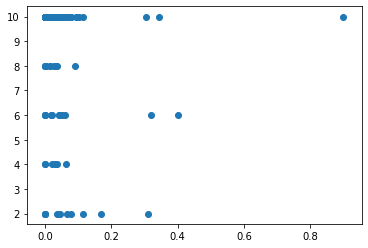

In [220]:
# do a scatter plot of this. 
plt.scatter(prd['probs'], prd['rep'])

In [225]:
means = prd.groupby('rep').mean()
means

,probs
rep,
2,0.081718
4,0.025102
6,0.083610
8,0.023622
10,0.054777


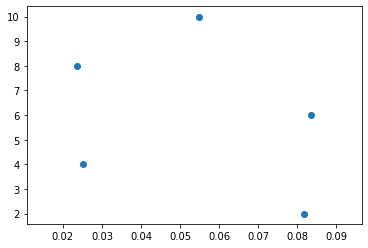

In [226]:
plt.scatter(means['probs'], means.index)

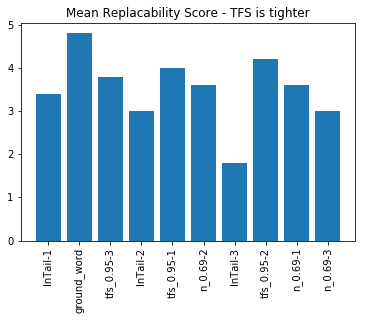

In [276]:
bar_plot_columns(prd, 'TFS is tighter')

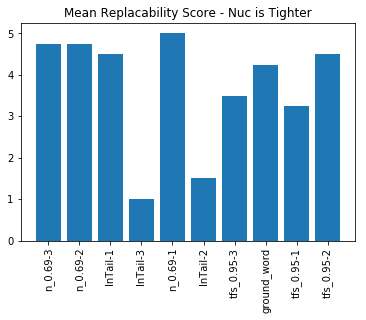

In [279]:
bar_plot_columns(nuc_tighter, 'Nuc is Tighter')

Want when Nuc is tighter for the difference between Nuc and TFS to be smaller than it is when TFS is tighter. 

In [280]:
abs_diff_of_different_locations(tfs_tighter, tfs_label, n_label)

position: 1 = 0.3999999999999999
position: 2 = 0.6000000000000001
position: 3 = 0.7999999999999998


In [281]:
abs_diff_of_different_locations(nuc_tighter,tfs_label, n_label)

position: 1 = 1.75
position: 2 = 0.25
position: 3 = 1.25
